### Qwen2-VL - Multimodal Model Integration

> The code of **Qwen2-VL** has been integrated into the latest Hugging Face `transformers` library.  
> This allows powerful vision-language capabilities such as document understanding, captioning, and multi-modal reasoning using unified models.

### Qwen-VL Utils Toolkit

> A toolkit to help handle various types of **visual input** more conveniently.  
> This includes support for:  
> - Base64 image strings  
> - Image/video URLs  
> - Interleaved multimedia content  
>  
> These utilities simplify pre-processing tasks before feeding data into Qwen2-VL or similar models.

### face_recognition – Accurate Face Recognition

> Recognize and manipulate faces from Python or even the command line using the **world's simplest face recognition library**.  
> Built using `dlib`'s deep learning models, it provides:  
> - Face detection  
> - Face encoding (into 128D vectors)  
> - Face comparison & recognition  
>  
>  The underlying model achieves **99.38% accuracy** on the **Labeled Faces in the Wild** benchmark.


In [1]:
!pip install face-recognition
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 17.0 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=168c41e7b95eb0099dd9016d9d03acf5294913ce86c854f7ed2b5e5f0ea098ad
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-cv15b6ew
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-cv15b6ew
  Resolved https://github.com/huggingface/transformers to commit d1b92369ca193da49f9f7ecd01b08ece45c2c9aa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.2/481.2 kB 9.1 MB/s eta

In [3]:
# Configure logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

### Import Statement Setup

In [2]:
# For face detection, face encoding, and face similarity calculations
# For visualizing images and detected faces (used mostly for visual inspection)
import face_recognition
import matplotlib.pyplot as plt

# From Hugging Face Transformers – used for multimodal document/image-text understanding
# Utility function, likely for processing visual-language inputs (e.g., OCR, layout)
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# Built-in library to compare sequences (e.g., text similarity using ratios)
from difflib import SequenceMatcher

# For structured logging throughout the application
# Type hinting support for function parameters and return values
import logging
from typing import List, Dict, Union

# Abstract Syntax Trees – could be used to safely evaluate or parse Python-like expressions
# Regular expressions
import ast
import re

### Load Image and Extract Face Region

> This block performs the steps to dispaly face images:
> 
> 1. **Load an input image** using the `face_recognition.load_image_file()` method.
> 2. **Detect face locations** in the image using `face_locations()`, which returns bounding box coordinates.
> 3. **Crop the face region** from the image using the detected coordinates.
> 4. **Display the extracted face** using `matplotlib.pyplot.imshow()` for visual confirmation.
> 
> This is helpful for verifying whether face detection is working correctly before performing face encoding or similarity comparison.


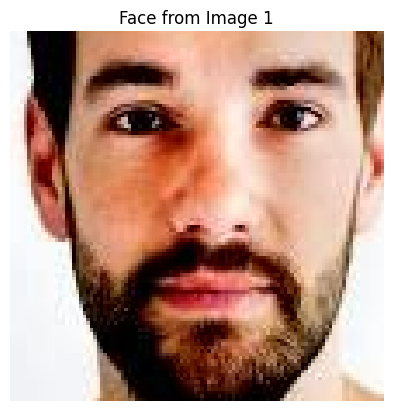

In [4]:
img1 = face_recognition.load_image_file("/kaggle/input/aadhar/2front_contrast_adjusted.jpg")
# Load the image
face_locations1 = face_recognition.face_locations(img1)

# Display the image
top, right, bottom, left = face_locations1[0]
face1 = img1[top:bottom, left:right]
plt.imshow(face1)
plt.title("Face from Image 1")
plt.axis('off')
plt.show()

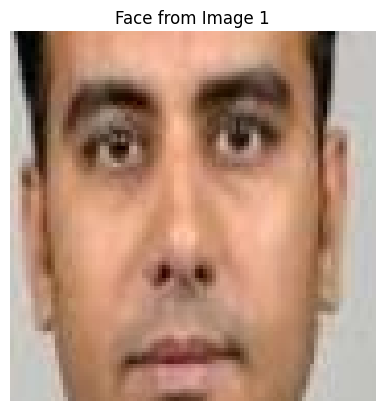

In [5]:
img2 = face_recognition.load_image_file("/kaggle/input/aadhar/7front_scaled_down.jpg")
# Load the image
face_locations2 = face_recognition.face_locations(img2)

# Display the image
top, right, bottom, left = face_locations2[0]
face2 = img2[top:bottom, left:right]
plt.imshow(face2)
plt.title("Face from Image 1")
plt.axis('off')
plt.show()

### Face Similarity Function – Compare Two Faces

> This function computes the **similarity score between two face images** using face embeddings.
> 
> #### How It Works:
> 1. **Loads both images** using `face_recognition.load_image_file()`.
> 2. **Detects and encodes faces** into 128-dimensional vectors using `face_encodings()`.
> 3. **Computes face distance** using `face_distance()`, which returns a Euclidean distance between encodings.
> 4. **Converts the distance into a similarity score** using:  
>    \[
>    \text{similarity} = 1 - \text{distance}
>    \]
> 
> #### Return Value:
> - Returns a float **between `0.0` (completely different)** and **`1.0` (exact match)**.
> - If a face is not found or any exception occurs, it safely returns `0.0` and logs a warning or error.
> 
> This function is useful for validating whether two face images belong to the same person.


In [6]:
def get_face_similarity(image1_path: str, image2_path: str) -> float:
    """
    Calculates the similarity score between faces in two images using face embeddings.

    Args:
        image1_path (str): File path to the first image containing a face.
        image2_path (str): File path to the second image containing a face.

    Returns:
        float: A similarity score between 0.0 (no match) and 1.0 (exact match).
               Returns 0.0 if a face is not detected or if any error occurs.
    """
    try:
        # Load images
        img1 = face_recognition.load_image_file(image1_path)
        img2 = face_recognition.load_image_file(image2_path)

        # Extract face encodings
        encoding1 = face_recognition.face_encodings(img1)
        encoding2 = face_recognition.face_encodings(img2)

        if encoding1 and encoding2:
            distance = face_recognition.face_distance([encoding1[0]], encoding2[0])[0]
            similarity = 1 - distance
            return round(similarity, 2)
        else:
            logger.warning("Face not detected in one or both images.")
            return 0.0

    except Exception as e:
        logger.error(f"Error computing face similarity: {e}")
        return 0.0

### Qwen2-VL Inference – Extract Information from Images

> This block uses the **Qwen2-VL-2B-Instruct** model to extract structured information (name and date of birth) from Aadhaar card images.  
> It demonstrates the process of loading a vision-language model, preparing input data, and generating structured output.

---

#### Step-by-Step Breakdown:

1. **Model Loading**  
   Loads the `Qwen2VLForConditionalGeneration` model using Hugging Face with `torch_dtype="auto"` and `device_map="auto"`  
   → This ensures automatic device assignment (GPU/CPU) and optimal precision.

2. **Processor Initialization**  
   Loads the `AutoProcessor` for Qwen2-VL, which handles text/image preprocessing and formatting.

3. **Prepare Input Prompt**  
   - Inputs include **two image paths** and a **natural language prompt** asking for:
     - `name`
     - `dob` (date of birth)
   - The instruction specifies that results must be returned as a list of dictionaries in a specific format.

4. **Visual Preprocessing**  
   Uses `process_vision_info()` to load and prepare images for model consumption.

5. **Tokenization and Tensor Conversion**  
   - Combines prompt and image data using the processor.
   - Converts to PyTorch tensors and pushes them to the appropriate device (`cuda` in this case).

6. **Text Generation (Inference)**  
   - Uses `model.generate()` to produce a response.
   - Extracts only the new tokens generated (excluding the original input).
   - Decodes the generated tokens into plain text output.

---

#### Output
> The model returns a clean list of dictionaries containing the extracted name and date of birth from each image.

Example output:
```python
[{'image': '2front_contrast_adjusted.jpg', 'name': 'Rahul Sharma', 'dob': '05-07-1992'},
 {'image': '7front_scaled_down.jpg', 'name': 'Anjali Mehta', 'dob': '18-11-1986'}]


In [7]:
# Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "/kaggle/input/aadhar/2front_contrast_adjusted.jpg"
            },
            {
                "type": "image",
                "image": "/kaggle/input/aadhar/7front_scaled_down.jpg",
            },
            {"type": "text", "text": (
                    "Extract only the **name** and **DOB** from each image. "
                    "Return a Python list where each item is a dictionary in the following format:\n\n"
                    "{'image': 'image_name.jpg', 'name': 'Full Name', 'dob': 'DD-MM-YYYY'}\n\n"
                    "Ensure the keys are lowercase and use only this format in the response without any markdown or additional text."
                ),},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

["```python\n[\n    {'image': 'aadhar_card_1.jpg', 'name': 'John Loyal', 'dob': '01-01-1995'},\n    {'image': 'aadhar_card_2.jpg', 'name': 'Dhruva', 'dob': '02-03-1993'}\n]\n```"]


### Extract Name and DOB from Model Output

> This utility function parses the **structured response** generated by the Qwen2-VL model and converts it into a usable Python object.
> 
> #### Purpose:
> To safely extract a list of dictionaries (with `'name'` and `'dob'`) from a markdown-formatted string or code block returned by the model.

---

In [8]:
def extract_name_dob(text_list: List[str]) -> List[dict]:
    """
    Converts a markdown-wrapped string containing either a single dictionary or a list of two dictionaries
    into a list with two dictionaries.

    If a single dictionary is detected, it duplicates it.
    If two dictionaries are already present, it returns as is.

    Args:
        text_list (List[str]): List containing a single markdown-wrapped string.

    Returns:
        List[dict]: List of two dictionaries.
    """
    if not text_list:
        return []

    text = " ".join(text_list)

    # Extract content between the markdown code block
    match = re.search(r"```python\n(.*?)\n```", text, re.DOTALL)
    if not match:
        return []

    try:
        parsed = ast.literal_eval(match.group(1).strip())

        if isinstance(parsed, dict):
            # Duplicate single dictionary
            return [parsed.copy(), parsed.copy()]

        elif isinstance(parsed, list) and len(parsed) == 2:
            return parsed

    except Exception as e:
        print(f"Error parsing input: {e}")
        return []

    return []

extracted_text = extract_name_dob(output_text)

In [9]:
print(extracted_text)

[{'image': 'aadhar_card_1.jpg', 'name': 'John Loyal', 'dob': '01-01-1995'}, {'image': 'aadhar_card_2.jpg', 'name': 'Dhruva', 'dob': '02-03-1993'}]


### Text-Based Similarity – Name & DOB Matching

> This function calculates the **textual similarity** between two sets of personal data (name and date of birth), typically extracted from document images.

---

#### Purpose:
To compare whether two entries (e.g. from different images of an ID card) represent the same person using simple string matching logic.

---


In [10]:
def text_similarity(data_list: List[Dict[str, Union[str, None]]]) -> float:
    """
    Computes similarity score between two data dictionaries containing 'name' and 'dob'.

    Args:
        data_list (List[Dict[str, Union[str, None]]]): A list of two dictionaries, each with 'name' and 'dob' keys.

    Returns:
        float: A score between 0.0 and 1.0 indicating the average similarity of names and DOBs.
    """
    try:
        if not isinstance(data_list, list) or len(data_list) != 2:
            raise ValueError("Expected a list of exactly 2 dictionaries")

        data1, data2 = data_list

        name1 = data1.get("name", "")
        dob1 = data1.get("dob", "")
        name2 = data2.get("name", "")
        dob2 = data2.get("dob", "")

        name_score = SequenceMatcher(None, name1, name2).ratio() if name1 and name2 else 0.0
        dob_score = 1.0 if dob1 and dob2 and dob1 == dob2 else 0.0

        return round((name_score + dob_score) / 2, 2)

    except Exception as e:
        logger.error(f"Error computing text similarity: {e}")
        return 0.0

### Final Similarity Score – Weighted Aggregation

> This function combines the **face similarity score** and **text similarity score** into a single final score using weighted averaging.

---

#### Purpose:
To generate a **comprehensive similarity metric** by blending results from both face recognition and text extraction analysis.

---

#### ⚙️ How It Works:

1. **Inputs**:
   - `face_score`: A float or int indicating how similar the two faces are (0.0 to 1.0).
   - `text_score`: A float or int indicating how similar the name and DOB are (0.0 to 1.0).
   - `face_weight`: Weight assigned to the face score (default: `0.6`).
   - `text_weight`: Weight assigned to the text score (default: `0.4`).

2. **Score Calculation**:
   Uses a **weighted average formula** to compute the final score:

   \[
   \text{final\_score} = (\text{face\_score} \times \text{face\_weight}) + (\text{text\_score} \times \text{text\_weight})
   \]

3. **Rounding**:
   The result is rounded to **2 decimal places** for clarity.

4. **Error Handling**:
   In case of unexpected input or runtime errors, the function logs an error and returns `0.0`.

---

#### Example:
```python
# Face match = 90%, Text match = 70%
calculate_final_score(0.9, 0.7) → 0.82


In [11]:
def calculate_final_score(
    face_score: Union[float, int],
    text_score: Union[float, int],
    face_weight: float = 0.6,
    text_weight: float = 0.4
) -> float:
    """
    Calculates the final weighted score from face and text similarity scores.

    Args:
        face_score (Union[float, int]): Similarity score based on face recognition.
        text_score (Union[float, int]): Similarity score based on text comparison.
        face_weight (float, optional): Weight for face score. Defaults to 0.6.
        text_weight (float, optional): Weight for text score. Defaults to 0.4.

    Returns:
        float: Final weighted similarity score rounded to two decimal places.
    """
    try:
        final_score = face_score * face_weight + text_score * text_weight
        return round(final_score, 2)
    except Exception as e:
        logger.error(f"Error calculating final score: {e}")
        return 0.0

In [12]:
face_score = get_face_similarity("/kaggle/input/aadhar/2front_contrast_adjusted.jpg", "/kaggle/input/aadhar/7front_scaled_down.jpg")
text_similarity_score = text_similarity(extracted_text)
final_score = calculate_final_score(face_score, text_similarity_score)

In [13]:
print("Face Score:", face_score)
print("Text Score:", text_similarity_score)
print("Overall Similarity Score:", final_score)

Face Score: 0.26
Text Score: 0.12
Overall Similarity Score: 0.2
